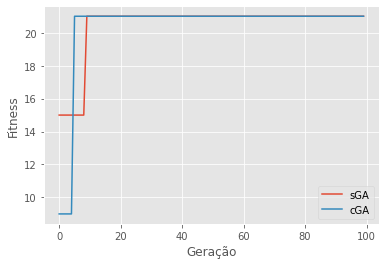

In [0]:
## ALGORITMO GENETICO COMPACTO e SIMPLES GERAÇÕES MULTIOBJETIVA
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

progress_cga = []
progress_sga = []

###################          SGA        ###################

# geração da população
def generate_pop_sga(size,population_size):
    sga_vector_pop = []

    for ps in range(population_size):
      sga_value = ''
      for s in range(size):
        sga_value += '1' if random.random() > 0.5  else '0'
      sga_vector_pop.append( {'val':sga_value,'fit':0} )

    return sga_vector_pop

# cruzamento dos individuos
def crossover_sga(size,population,mutation):
    son = population[0].copy()
    son2 = population[1].copy()

    s = son['val']
    s2 = son2['val']
    middle = random.randrange(1,size-1)
    
    son['fit'] = 0
    son2['fit'] = 0
    son['val'] = s[:middle] + s2[middle:]
    son2['val'] = s2[:middle] + s[middle:]
  
    # mutation
    child = son['val']
    child2 = son2['val']
    c1 = ""
    for c in child:
      mut = random.random()
      if(mut < mutation):
        c1+='1' if c == '0' else '0'
      else:
        c1+=c
    son['val'] = c1

    c2 = ""
    for s in child2:
      mut = random.random()
      if(mut < mutation):
        c2+='1' if s == '0' else '0'
      else:
        c2+=s
    son2['val'] = c2

    return son,son2

# algoritmo nsga que gera os individuos dominantes e não dominantes
def nsga2(population):
  front = [[]]
  s = [[] for i in range(len(population))]
  n = [0 for i in range(len(population))]
  rank = [0 for i in range(len(population))]
  
  for p in range(len(population)):
    s[p] = []
    n[p] = 0
    pfit = population[p]
    pft5, pift5 = pfit['fit']
    for q in range(len(population)):
      qfit = population[q]
      qft5, qift5 = qfit['fit']
      if ((pft5 > qft5 and pift5 > qift5) or (pft5 >= qft5 and pift5 > qift5)
        or (pft5 > qft5 and pift5 >= qift5)):   # Se p domina q
          s[p].append(q)  # Adiciona q no conjunto de soluções dominadas por p
      elif ((qft5 > pft5 and qift5 > pift5) or (qft5 >= pft5 and qift5 > pift5)
        or (qft5 > pft5 and qift5 >= pift5)):
          n[p] += 1      # Incrementa a contador da dominação de p 
    if n[p] == 0:        # p perntece ao primeiro front
      rank[p] = 0
      if p not in front[0]:
        front[0].append(p)
  i = 0                   # Inicializa o contador do front
  while front[i] != []:
    aux = []              # Usado para armazenar o numero de membros para o proximo front
    for p in front[i]:
      for q in s[p]:
        n[q] = n[q] - 1
        if n[q] == 0:     # q pertence ao proximo front
          rank[q] = i + 1
          if q not in aux:
            aux.append(q)
    i += 1
    front.append(aux)
  
  del front[len(front) - 1]

  sorted_pop = []
  for f in front:
    for i in f:
      sorted_pop.append(population[i])
  #print(sorted_pop)
  return sorted_pop

# execução do algoritmo
def run_sga(generations, size, population_size):
    # criação da população aleatoria
    population = generate_pop_sga(size,population_size)
    population = fitness_function_sga(population)
    population = nsga2(population)

    mutation = 0.01

    # percorre as gerações
    for i in range(generations):

      mid = int(population_size/2) if int(population_size/2) % 2 == 0 else int(population_size/2)-1
      new_population = []
      
      for j in range(0,mid,2):
        new_population += crossover_sga(size,population[j:j+2],mutation)

      full_pop = population + new_population
      full_pop = fitness_function_sga(full_pop)

      full_pop = nsga2(full_pop)

      population = full_pop[:population_size]
      
      #print ("generation: {} and population {}".format(i + 1,population))
      p = population[0]
      ft5,fift5 = p['fit']
      progress_sga.append(ft5+fift5)

# ordenação dos individuos
def sort_fit(e):
  return e['fit']

# Define fitness function (ftrap5)
def ftrap5(individual):
  u = 0
  for a in individual:
    u += int(a)
  if u < 5:
    return 4 - u
  return 5

# Define fitness function (inftrap5)
def inftrap5(individual):
  u = 0
  for a in individual:
    u += int(a)
  if u > 0:
    return u -1
  return 5

# funcao de fitness
def fitness_function_sga(population):
  vector_fit = []

  for p in population:
    ft = 0
    ift = 0
    individuo = p['val']
    for i in [individuo[:5], individuo[5:10], individuo[10:15]]:
      ft+= ftrap5(i)
      ift+= inftrap5(i)
    p['fit']= ft,ift
    vector_fit.append(p)

  #vector_fit.sort(reverse = True,key=sort_fit)
  
  return vector_fit

###################          CGA        ###################

# estrutura do algoritmo do cga
class Solution(object):
    def __init__(self, value):
        self.value = value
        self.fitness = 0

    def calculate_fitness(self):
        self.fitness = fitness_function(self.value)

# criação dos individuos
def generate_candidate(vector):
    value = ""

    for p in vector:
        value += "1" if random.random() < p else "0"

    return Solution(value)

# criação do vetor de probabilidades
def generate_vector(size):
    return [0.5] * size

# competição dos fitness
def compete(a, b):
    pft5, pift5 = a.fitness
    qft5, qift5 = b.fitness
    if ((pft5 > pift5 and qft5 > qift5) or (pft5 >= pift5 and qft5 > qift5)
      or (pft5 > pift5 and qft5 >= qift5)):
        return a, b
    else:
      return b, a

# atualiza o vetor de probabilidade
def update_vector(vector, winner, loser, population_size):
    for i in range(len(vector)):
        if winner[i] != loser[i]:
            if winner[i] == '1':
                vector[i] += 1.0 / float(population_size)
            else:
                vector[i] -= 1.0 / float(population_size)

# execução do algoritmo
def run_cga(generations, size, population_size):
    # probabilidade de vetor ser 1
    vector = generate_vector(size)
    best = None

    for i in range(generations):
        # gerandos dois individuos
        s1 = generate_candidate(vector)
        s2 = generate_candidate(vector)

        # calculo de fitness de cada um 
        s1.calculate_fitness()
        s2.calculate_fitness()

        # competição entre os individuos
        winner, loser = compete(s1, s2)

        # verifica qual é o melhor
        if best:
            if winner.fitness > best.fitness:
                best = winner
        else:
            best = winner

        # atualiza o vetor com base na probabilidade
        update_vector(vector, winner.value, loser.value, population_size)
        #print ("generation: {} best value: {} best fitness: {}".format(i + 1, best.value, float(best.fitness)) )

        ft5,ift5 = best.fitness
        progress_cga.append(ft5+ift5)

# funcao de fitness
def fitness_function(individuo):
  ft = 0
  ift = 0
  for i in [individuo[:5], individuo[5:10], individuo[10:15]]:
      ft+= ftrap5(i)
      ift+= inftrap5(i)
  return ft,ift

# função que mostra o gráfico
def plotgraphics(progress_cga,progress_sga):
  line_sga, = plt.plot(progress_sga, label='sGA')
  line_cga, = plt.plot(progress_cga, label='cGA')
  plt.legend([line_sga, line_cga], ['sGA', 'cGA'])
  plt.xlabel('Geração')
  plt.ylabel('Fitness')
  plt.show()

# execução dos algoritmos
run_sga(100, 15, 10)
run_cga(100, 15, 10)
plotgraphics(progress_cga,progress_sga)